In [90]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [92]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [93]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [94]:
tf.keras.backend.clear_session()

In [95]:
subject = 'Amapá - Consumo de Cimento (t)'
start_index = 0
split_index = 155 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [96]:
data = pd.read_csv('2003_mo_model_input_AP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,2003-1,0.774101,10518.903600,0.711421,10.392,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881
1,2003-2,0.774476,10623.124754,0.711553,6.857,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071
2,2003-3,0.774851,10723.388458,0.711685,7.011,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261
3,2003-4,0.775226,10817.834529,0.711817,7.122,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450
4,2003-5,0.775601,10909.780391,0.711949,5.267,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


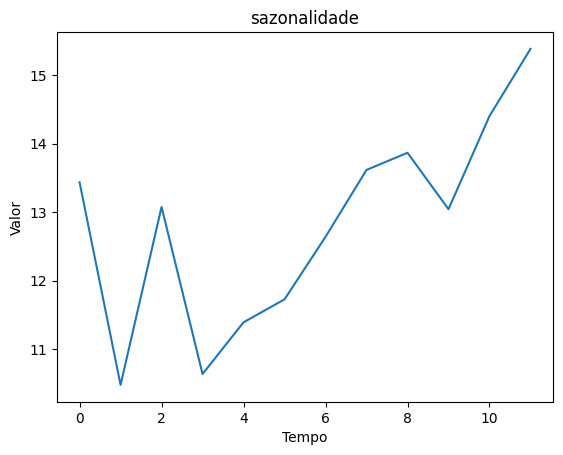

,sazonalidade
sazonalidade,
0,13.437022
1,10.478937
2,13.078086
3,10.637820
4,11.393302
5,11.728861
6,12.641289
7,13.618506
8,13.868784


In [97]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [98]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade,Amapá - Consumo de Cimento (t)
0,2003-1,0.774101,10518.903600,0.711421,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881,13.437022,10.392
1,2003-2,0.774476,10623.124754,0.711553,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071,10.478937,6.857
2,2003-3,0.774851,10723.388458,0.711685,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261,13.078086,7.011
3,2003-4,0.775226,10817.834529,0.711817,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450,10.637820,7.122
4,2003-5,0.775601,10909.780391,0.711949,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640,11.393302,5.267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.393302,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.728861,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.641289,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.618506,NaN


In [99]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      9.759
1      4.782
2      7.803
3      4.400
4      4.460
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Amapá - Consumo de Cimento (t), Length: 249, dtype: float64

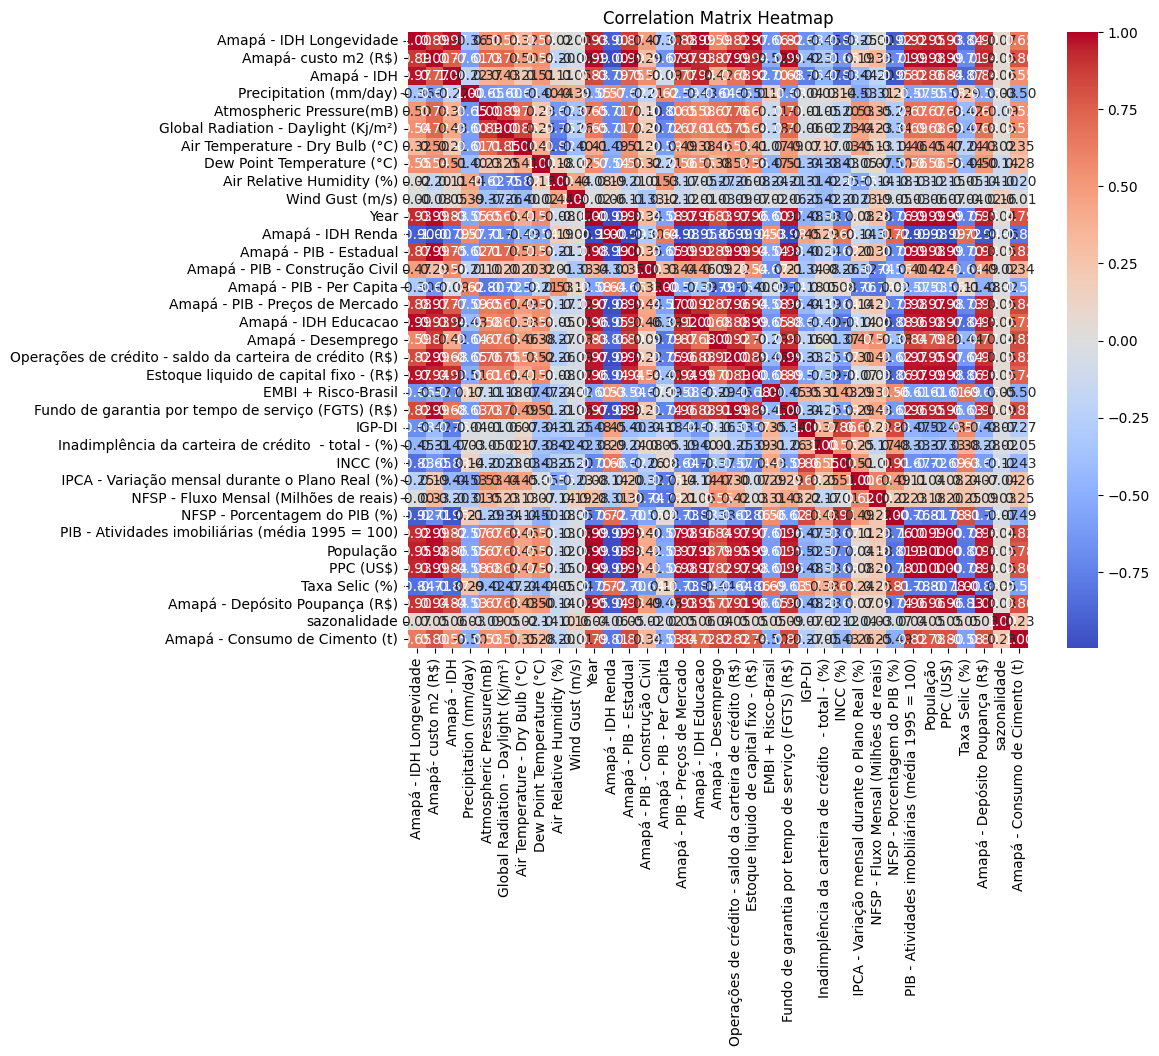

In [100]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [102]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amapá - IDH Longevidade,1.430089e+09
1,Amapá- custo m2 (R$),7.673670e+06
2,Amapá - IDH,2.249582e+05
3,Precipitation (mm/day),3.617616e+02
4,Atmospheric Pressure(mB),3.854208e+07
5,Global Radiation - Daylight (Kj/m²),2.377061e+03
6,Air Temperature - Dry Bulb (°C),1.750156e+06
7,Dew Point Temperature (°C),1.209770e+06
8,Air Relative Humidity (%),1.009566e+06
9,Wind Gust (m/s),4.563842e+03


In [103]:
# data =data.drop(['Wind Gust (m/s)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000000)
data

Num columns removed: 1


,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade
0,0.774101,10518.903600,0.711421,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,8.514392,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881,13.437022
1,0.774476,10623.124754,0.711553,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,8.508753,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071,10.478937
2,0.774851,10723.388458,0.711685,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,8.503114,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261,13.078086
3,0.775226,10817.834529,0.711817,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,8.497475,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450,10.637820
4,0.775601,10909.780391,0.711949,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,8.491835,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640,11.393302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.799656,23312.439058,0.718230,2.133032,1010.722308,1524.999860,26.488989,23.070324,82.549657,1.042332,2014.980331,0.671725,9.622629e+06,353706.423066,10.822547,7.376212e+06,16.363115,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,496483.112227,13.618506
152,0.800427,23403.052711,0.718459,2.042175,1010.616690,1484.018656,26.462083,22.980277,82.284133,1.063800,2014.986821,0.671378,9.627860e+06,352985.417356,10.821394,7.376830e+06,16.378431,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,494423.821932,13.868784
153,0.801199,23493.212475,0.718688,1.834124,1010.584557,1404.718331,26.215615,22.946234,83.220592,1.086663,2015.134027,0.671031,9.633091e+06,352264.411646,10.820241,7.377448e+06,16.393746,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,492364.531637,13.044524
154,0.801971,23583.862172,0.718917,1.819082,1010.539561,1277.955813,25.918617,23.102246,

In [104]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,-1.600373,-2.756341,0.019342,0.098380,-0.090267,0.390564,-1.288404,-1.287358,-0.688132,-1.727255,1.643344,-1.587937,-1.282997,-0.750468,-1.831785,-0.676726,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-1.485717
1,-1.573372,-2.686092,0.018317,0.100336,-0.087138,0.391378,-1.282475,-1.284215,-0.687050,-1.718888,1.623219,-1.566956,-1.270853,-0.701576,-1.797025,-0.678439,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-1.483243
2,-1.547396,-2.615842,0.017719,0.101478,-0.085313,0.391852,-1.279016,-1.282381,-0.686419,-1.714007,1.603093,-1.545975,-1.258709,-0.652684,-1.762264,-0.680152,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-1.480769
3,-1.522928,-2.545593,0.017655,0.101600,-0.085117,0.391903,-1.278646,-1.282185,-0.686352,-1.713484,1.582968,-1.524993,-1.246565,-0.603792,-1.727504,-0.681864,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-1.478295
4,-1.499107,-2.475343,0.026677,0.090779,-0.094040,0.380096,-1.267228,-1.261556,-0.683168,-1.702559,1.562842,-1.504012,-1.234420,-0.554900,-1.692744,-0.683577,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-1.475821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.714121,0.865415,0.393631,1.173244,1.740295,1.498830,0.238485,-1.548297,-0.049023,1.569778,-1.809564,1.547308,-1.900737,-2.186596,1.332931,1.707267,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123,0.909636
152,1.737597,0.987234,0.239975,1.087593,1.586194,1.462698,0.049544,-1.632063,0.218649,1.571526,-1.875892,1.557644,-2.055142,-2.213921,1.338638,1.711919,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135,0.892702
153,1.760955,1.109054,-0.111876,1.061535,1.288002,1.131702,-0.021886,-1.336635,0.503717,1.611172,-1.942219,1.567980,-2.209547,-2.241246,1.344345,1.716571,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308,0.875768
154,1.784440,1.230874,-0.137313,1.025045,0.811339,0.732850,0.305464,-0.688508,0.358826,1.655919,-2.008547,1.578315,-2.363952,-2.268571,1.350051,1.721223,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029,0.858833


In [105]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,-1.600373,-2.756341,0.019342,0.098380,-0.090267,0.390564,-1.288404,-1.287358,-0.688132,-1.727255,1.643344,-1.587937,-1.282997,-0.750468,-1.831785,-0.676726,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-1.485717
1,-1.573372,-2.686092,0.018317,0.100336,-0.087138,0.391378,-1.282475,-1.284215,-0.687050,-1.718888,1.623219,-1.566956,-1.270853,-0.701576,-1.797025,-0.678439,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-1.483243
2,-1.547396,-2.615842,0.017719,0.101478,-0.085313,0.391852,-1.279016,-1.282381,-0.686419,-1.714007,1.603093,-1.545975,-1.258709,-0.652684,-1.762264,-0.680152,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-1.480769
3,-1.522928,-2.545593,0.017655,0.101600,-0.085117,0.391903,-1.278646,-1.282185,-0.686352,-1.713484,1.582968,-1.524993,-1.246565,-0.603792,-1.727504,-0.681864,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-1.478295
4,-1.499107,-2.475343,0.026677,0.090779,-0.094040,0.380096,-1.267228,-1.261556,-0.683168,-1.702559,1.562842,-1.504012,-1.234420,-0.554900,-1.692744,-0.683577,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-1.475821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.421938,0.155431,-2.191981,1.276921,1.444316,0.630850,-0.294590,-1.031148,-0.566056,1.300450,-1.242194,1.405219,-0.286372,-1.708442,1.277290,1.588880,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621,1.004923
140,1.445718,0.126880,-2.309377,1.007257,1.391999,0.682645,-0.365529,-1.133225,-0.418768,1.302197,-1.262810,1.419166,-0.393078,-1.765818,1.280429,1.606045,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121,1.009574
141,1.469842,0.098330,-2.285462,0.900382,1.100365,0.456524,-0.182465,-0.755873,-0.307987,1.341844,-1.283426,1.433114,-0.499784,-1.823193,1.283568,1.623210,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902,1.014224
142,1.494636,0.069779,-2.423612,0.891415,0.787261,0.100840,-0.038898,-0.267577,-0.231719,1.386591,-1.304041,1.447062,-0.606489,-1.880569,1.286707,1.640374,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143,1.018875


In [106]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       9.759000
1       4.782000
2       7.803000
3       4.400000
4       4.460000
         ...    
139    15.480979
140    15.511384
141    15.421384
142    16.053289
143    13.580500
Name: Amapá - Consumo de Cimento (t), Length: 144, dtype: float64

In [107]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [108]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 31)

In [109]:
# input para treinamento
test_input = input_data.iloc[train_split-window_size:split_index + 1]
test_input

,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
108,0.654547,0.566895,-0.278517,0.175362,-0.055422,-0.610704,-0.290733,0.448431,-1.134863,0.687173,-0.644916,0.798093,1.864968,0.360643,0.986148,1.025370,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183,0.711359
109,0.676550,0.606302,-0.171381,0.333170,0.005033,-0.604995,-0.286027,0.457576,-1.103196,0.709075,-0.685666,0.822958,1.793500,0.301752,1.005999,1.045722,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767,0.797903
110,0.700551,0.645709,-0.098742,0.651423,0.175810,-0.463622,-0.204132,0.373586,-1.083469,0.727713,-0.726415,0.847824,1.722032,0.242861,1.025849,1.066073,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482,0.884448
111,0.724004,0.685117,-0.169665,0.852139,0.336130,-0.386060,-0.150088,0.340428,-1.477975,0.741760,-0.767164,0.872690,1.650565,0.183970,1.045700,1.086425,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413,0.970993
112,0.748010,0.724524,0.022907,1.189378,0.661269,-0.200303,-0.397949,-0.005951,-1.463253,0.749558,-0.807913,0.897555,1.579097,0.125079,1.065550,1.106776,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135,1.057538
113,0.771879,0.763932,-0.019671,1.442387,1.026158,0.102463,-0.805160,-0.552493,-1.199746,0.755342,-0.848663,0.922421,1.507629,0.066188,1.085401,1.127127,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280,1.144082
114,0.795707,0.803339,-0.154114,1.264089,1.287036,0.481225,-1.230816,-1.174735,-0.846014,0.759289,-0.889412,0.947287,1.436161,0.007297,1.105252,1.147479,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452,1.230627
115,0.819616,0.842746,-0.029395,1.019255,1.522282,0.859891,-1.637372,-1.780600,-0.238250,0.761793,-0.930161,0.972152,1.364694,-0.051594,1.125102,1.167830,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037,1.317172
116,0.841918,0.882154,-0.170081,0.628583,1.480496,0.996275,-1.809316,-2.013102,0.196151,0.763540,-0.970910,0.997018,1.293226,-0.110484,1.144953,1.188182,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721,1.403716
117,0.863783,0.921561,-0.235071,0.373707,1.228819,0.857401,-1.655537,-1.802920,0.778500,0.803187,-1.011660,1.021884,1.221758,-0.169375,1.164803,1.208533,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.900088,0.977769,-1.241995,1.490261


In [110]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 31)

In [111]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [112]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [113]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [114]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2609152443, 794179584, 573072490, 508311453, 3254687692, 3589348008, 1264174590, 2359261076, 3911373222, 2459790410]


Step: 0 ___________________________________________
val_loss: 0.7525792717933655
winner_seed: 2609152443


Step: 1 ___________________________________________
val_loss: 0.7156572937965393
winner_seed: 794179584


Step: 2 ___________________________________________
val_loss: 1.018081545829773


Step: 3 ___________________________________________
val_loss: 0.7628385424613953


Step: 4 ___________________________________________
val_loss: 1.1060538291931152


Step: 5 ___________________________________________
val_loss: 1.0204086303710938


Step: 6 ___________________________________________
val_loss: 1.115364670753479


Step: 7 ___________________________________________
val_loss: 0.9673892259597778


Step: 8 ___________________________________________
val_loss: 0.689168393611908
winner_seed: 3911373222


Step: 9 ___________________________________________
val_loss: 0.8

In [115]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2963195227

Epoch 1/10000
4/4 [==============================] - 2s 117ms/step - loss: 257.2012 - val_loss: 62.8470
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.6617 - val_loss: 4.3096
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.9625 - val_loss: 5.0181
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.8169 - val_loss: 56.1896
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.8342 - val_loss: 21.5378
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.0433 - val_loss: 9.2289
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.3654 - val_loss: 41.8272
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.4082 - val_loss: 15.7929
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.4821 - val_loss: 42.5800
Epoch 10/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.7430 - val_l

4/4 [==============================] - 0s 9ms/step - loss: 7.6896 - val_loss: 5.7704
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.5395 - val_loss: 9.8315
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.7029 - val_loss: 2.7197
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3988 - val_loss: 9.3051
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.5753 - val_loss: 2.4091
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.0178 - val_loss: 4.9495
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3845 - val_loss: 4.1041
Epoch 89/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5949 - val_loss: 11.9000
Epoch 90/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.5017 - val_loss: 2.9241
Epoch 91/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1320 - val_loss: 2.4914
Epoch 9

4/4 [==============================] - 0s 9ms/step - loss: 7.1575 - val_loss: 6.8517
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8275 - val_loss: 15.2124
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.3737 - val_loss: 4.6785
Epoch 166/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4224 - val_loss: 11.5524
Epoch 167/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.1286 - val_loss: 4.9825
Epoch 168/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3038 - val_loss: 5.6967
Epoch 169/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9750 - val_loss: 10.8211
Epoch 170/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9073 - val_loss: 6.0583
Epoch 171/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1376 - val_loss: 5.8789
Epoch 172/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.9944 - val_loss: 6.5236
E

4/4 [==============================] - 0s 9ms/step - loss: 6.0992 - val_loss: 5.2896
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2148 - val_loss: 5.5314
Epoch 246/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2577 - val_loss: 4.6516
Epoch 247/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5933 - val_loss: 2.1224
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8426 - val_loss: 8.3815
Epoch 249/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9012 - val_loss: 4.7394
Epoch 250/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6995 - val_loss: 3.5251
Epoch 251/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5951 - val_loss: 2.9144
Epoch 252/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6538 - val_loss: 6.3638
Epoch 253/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6392 - val_loss: 2.1286
Epoch 

4/4 [==============================] - 0s 10ms/step - loss: 5.8802 - val_loss: 2.6119
Epoch 326/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2459 - val_loss: 2.2867
Epoch 327/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3092 - val_loss: 3.1250
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8324 - val_loss: 3.9515
Epoch 329/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1955 - val_loss: 2.1390
Epoch 330/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2361 - val_loss: 2.7905
Epoch 331/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9405 - val_loss: 1.7856
Epoch 332/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.4081 - val_loss: 6.6001
Epoch 333/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1806 - val_loss: 4.6903
Epoch 334/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3421 - val_loss: 2.9550
Epoch

4/4 [==============================] - 0s 9ms/step - loss: 5.6235 - val_loss: 2.9726
Epoch 407/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9999 - val_loss: 3.1877
Epoch 408/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3380 - val_loss: 2.3642
Epoch 409/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8779 - val_loss: 2.1653
Epoch 410/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6820 - val_loss: 1.9722
Epoch 411/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5753 - val_loss: 1.9783
Epoch 412/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2992 - val_loss: 1.8235
Epoch 413/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8579 - val_loss: 2.1070
Epoch 414/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9444 - val_loss: 1.9231
Epoch 415/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6732 - val_loss: 3.9184
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 4.5048 - val_loss: 1.7899
Epoch 488/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3896 - val_loss: 1.8873
Epoch 489/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5040 - val_loss: 1.8249
Epoch 490/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7010 - val_loss: 1.7651
Epoch 491/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8506 - val_loss: 2.4063
Epoch 492/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0345 - val_loss: 1.8241
Epoch 493/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4820 - val_loss: 1.9633
Epoch 494/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9183 - val_loss: 1.8161
Epoch 495/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4627 - val_loss: 1.8676
Epoch 496/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7118 - val_loss: 2.0555
Epoch

4/4 [==============================] - 0s 9ms/step - loss: 4.3311 - val_loss: 1.7028
Epoch 569/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5430 - val_loss: 2.5700
Epoch 570/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8434 - val_loss: 1.9113
Epoch 571/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7174 - val_loss: 1.6755
Epoch 572/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2698 - val_loss: 1.6326
Epoch 573/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4059 - val_loss: 1.5719
Epoch 574/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2735 - val_loss: 2.0669
Epoch 575/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5290 - val_loss: 1.9514
Epoch 576/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4835 - val_loss: 1.5605
Epoch 577/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6947 - val_loss: 1.8234
Epo

4/4 [==============================] - 0s 9ms/step - loss: 4.5174 - val_loss: 1.8810
Epoch 650/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2259 - val_loss: 1.5361
Epoch 651/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8307 - val_loss: 1.4481
Epoch 652/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2686 - val_loss: 1.5214
Epoch 653/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7218 - val_loss: 1.5001
Epoch 654/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0162 - val_loss: 1.5196
Epoch 655/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2344 - val_loss: 1.6296
Epoch 656/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9047 - val_loss: 2.8810
Epoch 657/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5804 - val_loss: 1.9149
Epoch 658/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8879 - val_loss: 1.6771
Epoc

4/4 [==============================] - 0s 9ms/step - loss: 4.8979 - val_loss: 1.4427
Epoch 731/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7528 - val_loss: 1.6447
Epoch 732/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0410 - val_loss: 1.4699
Epoch 733/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7893 - val_loss: 1.6384
Epoch 734/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3067 - val_loss: 1.3924
Epoch 735/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0277 - val_loss: 1.4450
Epoch 736/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8705 - val_loss: 1.4102
Epoch 737/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9267 - val_loss: 1.4468
Epoch 738/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8929 - val_loss: 1.5439
Epoch 739/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2407 - val_loss: 1.5077
Epo

4/4 [==============================] - 0s 9ms/step - loss: 4.0540 - val_loss: 1.7499
Epoch 812/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9361 - val_loss: 1.4402
Epoch 813/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8300 - val_loss: 4.1732
Epoch 814/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7468 - val_loss: 1.9256
Epoch 815/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9357 - val_loss: 1.6804
Epoch 816/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9656 - val_loss: 1.9209
Epoch 817/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5023 - val_loss: 1.6027
Epoch 818/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9655 - val_loss: 1.9572
Epoch 819/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9842 - val_loss: 4.8863
Epoch 820/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8259 - val_loss: 2.0502
Epoch

4/4 [==============================] - 0s 9ms/step - loss: 3.3706 - val_loss: 1.7920
Epoch 893/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1318 - val_loss: 1.2875
Epoch 894/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4950 - val_loss: 1.5854
Epoch 895/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5566 - val_loss: 2.8249
Epoch 896/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7235 - val_loss: 2.1412
Epoch 897/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3041 - val_loss: 1.3563
Epoch 898/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4914 - val_loss: 2.2399
Epoch 899/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7437 - val_loss: 2.6410
Epoch 900/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5872 - val_loss: 1.7776
Epoch 901/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6195 - val_loss: 1.4563
Epoc

4/4 [==============================] - 0s 9ms/step - loss: 4.7408 - val_loss: 2.3275
Epoch 974/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3668 - val_loss: 1.2723
Epoch 975/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7889 - val_loss: 1.5855
Epoch 976/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9199 - val_loss: 1.9989
Epoch 977/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5670 - val_loss: 1.6833
Epoch 978/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5251 - val_loss: 1.5877
Epoch 979/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2962 - val_loss: 2.0444
Epoch 980/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5331 - val_loss: 1.5756
Epoch 981/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4483 - val_loss: 1.8211
Epoch 982/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0648 - val_loss: 2.1808
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 3.2801 - val_loss: 2.1619
Epoch 1054/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4558 - val_loss: 1.7494
Epoch 1055/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5651 - val_loss: 1.1953
Epoch 1056/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7980 - val_loss: 1.4709
Epoch 1057/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7417 - val_loss: 1.1818
Epoch 1058/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0164 - val_loss: 1.3014
Epoch 1059/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0402 - val_loss: 1.1771
Epoch 1060/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7555 - val_loss: 1.7134
Epoch 1061/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6678 - val_loss: 1.4816
Epoch 1062/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5198 - val_loss: 1.46

4/4 [==============================] - 0s 9ms/step - loss: 3.2226 - val_loss: 1.7367
Epoch 1134/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3073 - val_loss: 1.6802
Epoch 1135/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5040 - val_loss: 1.5007
Epoch 1136/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3263 - val_loss: 1.1027
Epoch 1137/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4072 - val_loss: 1.9323
Epoch 1138/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1697 - val_loss: 1.9612
Epoch 1139/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2048 - val_loss: 2.9491
Epoch 1140/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6617 - val_loss: 1.5752
Epoch 1141/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1349 - val_loss: 1.6560
Epoch 1142/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5280 - val_loss: 

4/4 [==============================] - 0s 9ms/step - loss: 3.0910 - val_loss: 2.4884
Epoch 1214/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1537 - val_loss: 1.2739
Epoch 1215/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4594 - val_loss: 1.0823
Epoch 1216/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3775 - val_loss: 1.2375
Epoch 1217/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0717 - val_loss: 2.7819
Epoch 1218/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8817 - val_loss: 1.5131
Epoch 1219/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1101 - val_loss: 1.5681
Epoch 1220/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1941 - val_loss: 1.1038
Epoch 1221/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1720 - val_loss: 1.5466
Epoch 1222/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9982 - val_loss: 

4/4 [==============================] - 0s 8ms/step - loss: 3.2434 - val_loss: 1.9612
Epoch 1294/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1571 - val_loss: 1.0851
Epoch 1295/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2362 - val_loss: 3.5974
Epoch 1296/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4632 - val_loss: 1.6885
Epoch 1297/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6881 - val_loss: 1.1849
Epoch 1298/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9961 - val_loss: 1.9830
Epoch 1299/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1052 - val_loss: 1.0686
Epoch 1300/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8789 - val_loss: 1.2957
Epoch 1301/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8688 - val_loss: 2.9163
Epoch 1302/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3326 - val_loss: 1.39

4/4 [==============================] - 0s 8ms/step - loss: 2.8564 - val_loss: 1.2593
Epoch 1374/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8765 - val_loss: 1.0828
Epoch 1375/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0205 - val_loss: 1.3892
Epoch 1376/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3545 - val_loss: 1.5091
Epoch 1377/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9667 - val_loss: 1.1664
Epoch 1378/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9607 - val_loss: 1.2352
Epoch 1379/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8875 - val_loss: 0.9950
Epoch 1380/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8855 - val_loss: 1.2104
Epoch 1381/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9347 - val_loss: 1.1941
Epoch 1382/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0941 - val_loss: 1.04

4/4 [==============================] - 0s 9ms/step - loss: 2.9586 - val_loss: 1.2645
Epoch 1454/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1943 - val_loss: 1.5557
Epoch 1455/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3304 - val_loss: 1.2221
Epoch 1456/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7307 - val_loss: 1.0864
Epoch 1457/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4798 - val_loss: 0.9627
Epoch 1458/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8829 - val_loss: 1.1142
Epoch 1459/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8962 - val_loss: 1.0472
Epoch 1460/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7205 - val_loss: 1.1617
Epoch 1461/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9881 - val_loss: 0.9686
Epoch 1462/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0080 - val_loss: 1.54

4/4 [==============================] - 0s 8ms/step - loss: 2.7271 - val_loss: 2.1116
Epoch 1534/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9795 - val_loss: 1.4231
Epoch 1535/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0961 - val_loss: 1.3425
Epoch 1536/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8007 - val_loss: 0.9313
Epoch 1537/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6936 - val_loss: 1.0585
Epoch 1538/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6252 - val_loss: 1.0497
Epoch 1539/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9015 - val_loss: 1.0476
Epoch 1540/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6354 - val_loss: 0.9827
Epoch 1541/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0865 - val_loss: 1.4024
Epoch 1542/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0014 - val_loss: 1.0

4/4 [==============================] - 0s 10ms/step - loss: 2.7649 - val_loss: 1.1816
Epoch 1614/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6015 - val_loss: 1.4947
Epoch 1615/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.8338 - val_loss: 1.0892
Epoch 1616/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6462 - val_loss: 1.0005
Epoch 1617/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6044 - val_loss: 1.3028
Epoch 1618/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7262 - val_loss: 1.1762
Epoch 1619/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6945 - val_loss: 1.1545
Epoch 1620/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7735 - val_loss: 1.0991
Epoch 1621/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7448 - val_loss: 2.1646
Epoch 1622/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2600 - val_loss: 

4/4 [==============================] - 0s 9ms/step - loss: 2.7634 - val_loss: 1.1118
Epoch 1694/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7831 - val_loss: 1.0123
Epoch 1695/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3907 - val_loss: 0.9887
Epoch 1696/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4107 - val_loss: 0.9804
Epoch 1697/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5540 - val_loss: 1.4359
Epoch 1698/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5319 - val_loss: 1.0618
Epoch 1699/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4955 - val_loss: 0.9636
Epoch 1700/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4323 - val_loss: 1.0700
Epoch 1701/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6724 - val_loss: 1.0314
Epoch 1702/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4463 - val_loss: 1.0

4/4 [==============================] - 0s 9ms/step - loss: 2.7658 - val_loss: 0.9704
Epoch 1774/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4350 - val_loss: 1.0336
Epoch 1775/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7194 - val_loss: 0.8811
Epoch 1776/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5130 - val_loss: 1.5639
Epoch 1777/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4099 - val_loss: 0.9524
Epoch 1778/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8986 - val_loss: 2.7815
Epoch 1779/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8912 - val_loss: 1.3283
Epoch 1780/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4144 - val_loss: 3.5221
Epoch 1781/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4420 - val_loss: 0.9861
Epoch 1782/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.6843 - val_loss: 0.9

4/4 [==============================] - 0s 9ms/step - loss: 2.2481 - val_loss: 0.9180
Epoch 1854/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3796 - val_loss: 1.1029
Epoch 1855/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6203 - val_loss: 1.0278
Epoch 1856/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3079 - val_loss: 0.9388
Epoch 1857/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2342 - val_loss: 0.9711
Epoch 1858/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3968 - val_loss: 0.9195
Epoch 1859/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3291 - val_loss: 0.8912
Epoch 1860/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5485 - val_loss: 1.5987
Epoch 1861/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7566 - val_loss: 0.9203
Epoch 1862/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5298 - val_loss: 1.01

4/4 [==============================] - 0s 8ms/step - loss: 2.3789 - val_loss: 0.9584
Epoch 1934/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2978 - val_loss: 1.0511
Epoch 1935/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5293 - val_loss: 1.0366
Epoch 1936/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4253 - val_loss: 0.9523
Epoch 1937/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4531 - val_loss: 0.9135
Epoch 1938/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1824 - val_loss: 0.8812
Epoch 1939/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4252 - val_loss: 1.1074
Epoch 1940/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4073 - val_loss: 1.0084
Epoch 1941/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2275 - val_loss: 0.9428
Epoch 1942/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2065 - val_loss: 0.94

4/4 [==============================] - 0s 9ms/step - loss: 2.1575 - val_loss: 0.8997
Epoch 2014/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0824 - val_loss: 0.8629
Epoch 2015/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3070 - val_loss: 0.9744
Epoch 2016/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4268 - val_loss: 0.8441
Epoch 2017/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2184 - val_loss: 0.8626
Epoch 2018/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2480 - val_loss: 0.9874
Epoch 2019/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3940 - val_loss: 0.8450
Epoch 2020/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2293 - val_loss: 0.8255
Epoch 2021/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2891 - val_loss: 1.0376
Epoch 2022/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2627 - val_loss: 

4/4 [==============================] - 0s 8ms/step - loss: 2.1139 - val_loss: 0.8104
Epoch 2094/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1239 - val_loss: 1.5182
Epoch 2095/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3873 - val_loss: 0.7784
Epoch 2096/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.1483 - val_loss: 0.8009
Epoch 2097/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2468 - val_loss: 0.7628
Epoch 2098/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4372 - val_loss: 0.9087
Epoch 2099/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5942 - val_loss: 1.1300
Epoch 2100/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5791 - val_loss: 0.8425
Epoch 2101/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2300 - val_loss: 0.8550
Epoch 2102/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3358 - val_loss: 0

4/4 [==============================] - 0s 10ms/step - loss: 2.4085 - val_loss: 0.9428
Epoch 2174/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4536 - val_loss: 0.9878
Epoch 2175/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0257 - val_loss: 0.8884
Epoch 2176/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0831 - val_loss: 0.8099
Epoch 2177/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2944 - val_loss: 0.7627
Epoch 2178/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1066 - val_loss: 0.7493
Epoch 2179/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0285 - val_loss: 0.7312
Epoch 2180/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1528 - val_loss: 0.8756
Epoch 2181/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8838 - val_loss: 0.9014
Epoch 2182/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0992 - val_loss: 0.

4/4 [==============================] - 0s 10ms/step - loss: 2.7401 - val_loss: 1.6920
Epoch 2254/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8175 - val_loss: 1.7923
Epoch 2255/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3027 - val_loss: 1.9950
Epoch 2256/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6267 - val_loss: 0.9807
Epoch 2257/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0735 - val_loss: 1.0733
Epoch 2258/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2961 - val_loss: 1.0288
Epoch 2259/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2282 - val_loss: 0.9468
Epoch 2260/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6119 - val_loss: 1.0087
Epoch 2261/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5865 - val_loss: 1.1803
Epoch 2262/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0537 - val_loss: 2.

4/4 [==============================] - 0s 8ms/step - loss: 2.0835 - val_loss: 0.7511
Epoch 2334/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9532 - val_loss: 1.1831
Epoch 2335/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6897 - val_loss: 1.2684
Epoch 2336/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3248 - val_loss: 0.7873
Epoch 2337/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1182 - val_loss: 0.9054
Epoch 2338/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.0365 - val_loss: 0.9103
Epoch 2339/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2487 - val_loss: 0.9405
Epoch 2340/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3951 - val_loss: 0.8099
Epoch 2341/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3714 - val_loss: 0.7807
Epoch 2342/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0463 - val_loss: 

4/4 [==============================] - 0s 9ms/step - loss: 1.7138 - val_loss: 0.9600
Epoch 2414/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9225 - val_loss: 1.3929
Epoch 2415/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8525 - val_loss: 1.2302
Epoch 2416/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7619 - val_loss: 1.1492
Epoch 2417/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8700 - val_loss: 1.3755
Epoch 2418/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7494 - val_loss: 1.8360
Epoch 2419/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9501 - val_loss: 1.4198
Epoch 2420/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9421 - val_loss: 1.4470
Epoch 2421/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8807 - val_loss: 1.9728
Epoch 2422/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8391 - val_loss: 2.20

4/4 [==============================] - 0s 8ms/step - loss: 1.8489 - val_loss: 3.7309
Epoch 2494/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8475 - val_loss: 2.8806
Epoch 2495/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9463 - val_loss: 2.3684
Epoch 2496/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8545 - val_loss: 1.3339
Epoch 2497/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8308 - val_loss: 1.6352
Epoch 2498/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0651 - val_loss: 1.9491
Epoch 2499/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8430 - val_loss: 1.0985
Epoch 2500/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7054 - val_loss: 1.3500
Epoch 2501/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9903 - val_loss: 2.5376
Epoch 2502/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8525 - val_loss: 0.9

4/4 [==============================] - 0s 8ms/step - loss: 1.7259 - val_loss: 1.4105
Epoch 2574/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7501 - val_loss: 1.1828
Epoch 2575/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8992 - val_loss: 3.4845
Epoch 2576/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6961 - val_loss: 1.2538
Epoch 2577/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6106 - val_loss: 1.6843
Epoch 2578/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6590 - val_loss: 3.2218
Epoch 2579/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7717 - val_loss: 2.1652
Epoch 2580/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6668 - val_loss: 2.6411
Epoch 2581/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6682 - val_loss: 2.2368
Epoch 2582/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9316 - val_loss: 2.48

4/4 [==============================] - 0s 8ms/step - loss: 3.3038 - val_loss: 7.4093
Epoch 2654/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2885 - val_loss: 9.4717
Epoch 2655/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1443 - val_loss: 8.3716
Epoch 2656/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9429 - val_loss: 7.4416
Epoch 2657/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3004 - val_loss: 7.8497
Epoch 2658/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0646 - val_loss: 4.1305
Epoch 2659/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8710 - val_loss: 4.8707
Epoch 2660/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9523 - val_loss: 8.6777
Epoch 2661/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0367 - val_loss: 4.7180
Epoch 2662/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6678 - val_loss: 8.9

4/4 [==============================] - 0s 9ms/step - loss: 1.7591 - val_loss: 5.7001
Epoch 2734/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6417 - val_loss: 6.1186
Epoch 2735/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.5952 - val_loss: 4.1778
Epoch 2736/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5259 - val_loss: 4.3578
Epoch 2737/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8107 - val_loss: 3.2660
Epoch 2738/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4015 - val_loss: 3.8128
Epoch 2739/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8467 - val_loss: 4.0332
Epoch 2740/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7439 - val_loss: 7.4629
Epoch 2741/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9878 - val_loss: 5.3771
Epoch 2742/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7619 - val_loss: 5.4

4/4 [==============================] - 0s 8ms/step - loss: 1.5892 - val_loss: 1.6902
Epoch 2814/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8806 - val_loss: 9.1629
Epoch 2815/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6912 - val_loss: 3.3146
Epoch 2816/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6221 - val_loss: 2.1029
Epoch 2817/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7252 - val_loss: 1.7165
Epoch 2818/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.5908 - val_loss: 3.3393
Epoch 2819/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.5036 - val_loss: 2.0032
Epoch 2820/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8007 - val_loss: 2.0649
Epoch 2821/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2166 - val_loss: 2.8086
Epoch 2822/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4683 - val_loss: 4.6

4/4 [==============================] - 0s 8ms/step - loss: 1.3830 - val_loss: 3.5050
Epoch 2894/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.4500 - val_loss: 5.1656
Epoch 2895/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4193 - val_loss: 3.6993
Epoch 2896/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.4548 - val_loss: 5.1927
Epoch 2897/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5987 - val_loss: 5.6800
Epoch 2898/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4725 - val_loss: 5.0563
Epoch 2899/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3665 - val_loss: 4.4831
Epoch 2900/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4444 - val_loss: 2.2476
Epoch 2901/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4538 - val_loss: 7.0494
Epoch 2902/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0530 - val_loss: 6.61

4/4 [==============================] - 0s 9ms/step - loss: 1.4442 - val_loss: 4.1923
Epoch 2974/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3353 - val_loss: 4.1775
Epoch 2975/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7301 - val_loss: 5.9750
Epoch 2976/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3804 - val_loss: 3.9855
Epoch 2977/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8886 - val_loss: 6.0994
Epoch 2978/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3852 - val_loss: 3.9785
Epoch 2979/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6923 - val_loss: 5.7653
Epoch 2980/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4827 - val_loss: 5.1616
Epoch 2981/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.3263 - val_loss: 6.4436
Epoch 2982/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.4757 - val_loss: 3.8

4/4 [==============================] - 0s 9ms/step - loss: 1.3352 - val_loss: 6.6761
Epoch 3054/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2373 - val_loss: 6.2103
Epoch 3055/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2823 - val_loss: 2.7630
Epoch 3056/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3265 - val_loss: 4.4182
Epoch 3057/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2607 - val_loss: 6.7810
Epoch 3058/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2857 - val_loss: 10.2763
Epoch 3059/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2857 - val_loss: 7.5733
Epoch 3060/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6999 - val_loss: 7.5492
Epoch 3061/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4029 - val_loss: 7.8256
Epoch 3062/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.3532 - val_loss: 5.

In [116]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [117]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,12.509863,11.631203,12.157001,12.13026,12.241663,13.006748,14.020308,14.312845,14.57448,14.327463,13.742424,12.594088
Target,12.495,8.322,11.373,9.651,10.855,13.97,12.399,11.268,8.741,12.358,11.876,11.713
Error,0.014863,3.309203,0.784001,2.47926,1.386663,0.963252,1.621307,3.044846,5.83348,1.969463,1.866424,0.881087


In [118]:
display(mae)
display(mape)

2.012821

0.1984549

In [119]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [120]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[157.24835]] - Target[135.02100000000002]| =  Error: [[22.227356]]; MAPE:[[0.16462147]]


[array([[22.227356]], dtype=float32)]

22.227356

0.16462147